# Optimierungsanalyse

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

In [ ]:
# Train: Features + Target in einer Datei
train_df = pd.read_csv("Data/preprocessed/train_preprocessed.csv")
train_X = train_df.drop(columns=["AdoptionSpeed"])
train_y = train_df["AdoptionSpeed"].astype(int).values

# Valid: Features und Target getrennt
valid_X = pd.read_csv("Data/preprocessed/valid_preprocessed.csv")
# Nur die Target-Spalte laden
valid_y = pd.read_csv("Data/preprocessed/valid_target.csv")["AdoptionSpeed"].astype(int).values.ravel()

# Test: Features und Target getrennt
test_X = pd.read_csv("Data/preprocessed/test_preprocessed.csv")
test_y = pd.read_csv("Data/preprocessed/test_target.csv")["AdoptionSpeed"].astype(int).values.ravel()


## 1. Random Search

In [11]:
# Kombiniere Train + Valid (für RandomizedSearchCV)
X_train = pd.concat([train_X, valid_X], axis=0)
y_train = np.concatenate([train_y, valid_y], axis=0)

In [12]:
# Modell
xgb = XGBClassifier(
    objective="multi:softmax",   # Multiklassifikation
    num_class=len(np.unique(y_train)),  # Anzahl Klassen automatisch bestimmen
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

In [15]:
# Hyperparameter-Suchraum
param_dist = {
    "max_depth": np.arange(3, 11),
    "learning_rate": np.linspace(0.01, 0.3, 30),
    "subsample": np.linspace(0.5, 1.0, 6),
    "n_estimators": np.arange(100, 1001, 100),
}

In [19]:
X_train = X_train.drop(columns=["PetID"])
valid_X = valid_X.drop(columns=["PetID"])
test_X  = test_X.drop(columns=["PetID"])


In [20]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:49:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='accuracy', verbose=1)

In [31]:
# Alle Object-/String-Spalten finden
object_cols = X_train.select_dtypes(include=["object", "string"]).columns

# Object-Spalten entfernen
X_train_clean = X_train.drop(columns=object_cols)
valid_X_clean = valid_X.drop(columns=object_cols)
test_X_clean  = test_X.drop(columns=object_cols)

# Kontrolle
print("Train shape:", X_train_clean.shape)
print("Valid shape:", valid_X_clean.shape)
print("Test shape:", test_X_clean.shape)


Train shape: (16120, 21)
Valid shape: (2845, 21)
Test shape: (2845, 21)


In [30]:
import xgboost as xgb

# DMatrix für XGBoost erstellen
dtrain = xgb.DMatrix(X_train_clean, label=y_train)
dvalid = xgb.DMatrix(valid_X_clean, label=valid_y)

# Parameter für XGBoost
params = {
    "objective": "multi:softmax",
    "num_class": len(np.unique(y_train)),
    "eval_metric": "mlogloss",
    **best_params  # aus RandomizedSearchCV
}

evals = [(dtrain, "train"), (dvalid, "valid")]

# Training mit Early Stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=True
)

# Vorhersage auf Testset
dtest = xgb.DMatrix(test_X_clean)
preds = bst.predict(dtest)


[0]	train-mlogloss:1.60433	valid-mlogloss:1.60441
[1]	train-mlogloss:1.59949	valid-mlogloss:1.59968
[2]	train-mlogloss:1.59473	valid-mlogloss:1.59498
[3]	train-mlogloss:1.59020	valid-mlogloss:1.59055
[4]	train-mlogloss:1.58540	valid-mlogloss:1.58581
[5]	train-mlogloss:1.58072	valid-mlogloss:1.58113


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [14:55:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[6]	train-mlogloss:1.57627	valid-mlogloss:1.57673
[7]	train-mlogloss:1.57190	valid-mlogloss:1.57245
[8]	train-mlogloss:1.56734	valid-mlogloss:1.56794
[9]	train-mlogloss:1.56271	valid-mlogloss:1.56330
[10]	train-mlogloss:1.55813	valid-mlogloss:1.55873
[11]	train-mlogloss:1.55374	valid-mlogloss:1.55447
[12]	train-mlogloss:1.54939	valid-mlogloss:1.55019
[13]	train-mlogloss:1.54513	valid-mlogloss:1.54597
[14]	train-mlogloss:1.54095	valid-mlogloss:1.54181
[15]	train-mlogloss:1.53665	valid-mlogloss:1.53757
[16]	train-mlogloss:1.53249	valid-mlogloss:1.53344
[17]	train-mlogloss:1.52839	valid-mlogloss:1.52934
[18]	train-mlogloss:1.52438	valid-mlogloss:1.52536
[19]	train-mlogloss:1.52027	valid-mlogloss:1.52128
[20]	train-mlogloss:1.51628	valid-mlogloss:1.51736
[21]	train-mlogloss:1.51241	valid-mlogloss:1.51351
[22]	train-mlogloss:1.50825	valid-mlogloss:1.50948
[23]	train-mlogloss:1.50421	valid-mlogloss:1.50544
[24]	train-mlogloss:1.50021	valid-mlogloss:1.50140
[25]	train-mlogloss:1.49637	valid-m

In [ ]:
# Beste Parameter
print("Beste Parameter:", random_search.best_params_)
print("Bester CV-Score:", random_search.best_score_)

In [ ]:
# Finale Bewertung auf Test
best_model = random_search.best_estimator_
y_pred = best_model.predict(test_X)

print("Accuracy (Test):", accuracy_score(test_y, y_pred))
print("Classification Report (Test):\n", classification_report(test_y, y_pred))

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier

# ======================
# 1. Daten laden
# ======================
train_df = pd.read_csv("Data/preprocessed/train_preprocessed.csv")
X_train = train_df.drop(columns=["AdoptionSpeed"])
y_train = train_df["AdoptionSpeed"].astype(int).values

valid_X = pd.read_csv("Data/preprocessed/valid_preprocessed.csv")
valid_y = pd.read_csv("Data/preprocessed/valid_target.csv")["AdoptionSpeed"].astype(int).values

test_X = pd.read_csv("Data/preprocessed/test_preprocessed.csv")
test_y = pd.read_csv("Data/preprocessed/test_target.csv")["AdoptionSpeed"].astype(int).values

# ======================
# 2. Object-Spalten entfernen
# ======================
object_cols = X_train.select_dtypes(include=["object", "string"]).columns
X_train_clean = X_train.drop(columns=object_cols)
valid_X_clean = valid_X.drop(columns=object_cols)
test_X_clean  = test_X.drop(columns=object_cols)

# ======================
# 3. RandomizedSearchCV für Hyperparameter
# ======================
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train)),
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)

# Beispielparameter-Raum (anpassen)
param_dist = {
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 200, 300, 500],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_clean, y_train)

best_params = random_search.best_params_
print("Beste Parameter:", best_params)

# ======================
# 4. Bestes Modell mit xgb.train + Early Stopping
# ======================
# DMatrix erstellen
dtrain = xgb.DMatrix(X_train_clean, label=y_train)
dvalid = xgb.DMatrix(valid_X_clean, label=valid_y)
dtest  = xgb.DMatrix(test_X_clean)

# Parameter für xgb.train vorbereiten
params = {
    "objective": "multi:softmax",
    "num_class": len(np.unique(y_train)),
    "eval_metric": "mlogloss",
    **best_params
}

evals = [(dtrain, "train"), (dvalid, "valid")]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=True
)

# ======================
# 5. Vorhersage & Evaluation
# ======================
preds = bst.predict(dtest)

accuracy = accuracy_score(test_y, preds)
f1 = f1_score(test_y, preds, average="weighted")

print("Test Accuracy:", accuracy)
print("Test F1:", f1)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:53:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Beste Parameter: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}
[0]	train-mlogloss:1.57894	valid-mlogloss:1.59310
[1]	train-mlogloss:1.55076	valid-mlogloss:1.57877
[2]	train-mlogloss:1.51975	valid-mlogloss:1.56239
[3]	train-mlogloss:1.48526	valid-mlogloss:1.54132
[4]	train-mlogloss:1.45865	valid-mlogloss:1.52830
[5]	train-mlogloss:1.43703	valid-mlogloss:1.51852
[6]	train-mlogloss:1.41807	valid-mlogloss:1.51047
[7]	train-mlogloss:1.39845	valid-mlogloss:1.50211
[8]	train-mlogloss:1.37928	valid-mlogloss:1.49448
[9]	train-mlogloss:1.36075	valid-mlogloss:1.48630
[10]	train-mlogloss:1.34076	valid-mlogloss:1.47812
[11]	train-mlogloss:1.32685	valid-mlogloss:1.47331


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:53:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[12]	train-mlogloss:1.31332	valid-mlogloss:1.46850
[13]	train-mlogloss:1.29896	valid-mlogloss:1.46345
[14]	train-mlogloss:1.28452	valid-mlogloss:1.45827
[15]	train-mlogloss:1.27035	valid-mlogloss:1.45348
[16]	train-mlogloss:1.25574	valid-mlogloss:1.44701
[17]	train-mlogloss:1.24568	valid-mlogloss:1.44470
[18]	train-mlogloss:1.23483	valid-mlogloss:1.44169
[19]	train-mlogloss:1.22124	valid-mlogloss:1.43731
[20]	train-mlogloss:1.21262	valid-mlogloss:1.43520
[21]	train-mlogloss:1.20204	valid-mlogloss:1.43211
[22]	train-mlogloss:1.19242	valid-mlogloss:1.42936
[23]	train-mlogloss:1.18309	valid-mlogloss:1.42800
[24]	train-mlogloss:1.17197	valid-mlogloss:1.42410
[25]	train-mlogloss:1.16252	valid-mlogloss:1.42058
[26]	train-mlogloss:1.15350	valid-mlogloss:1.41784
[27]	train-mlogloss:1.14734	valid-mlogloss:1.41757
[28]	train-mlogloss:1.13843	valid-mlogloss:1.41389
[29]	train-mlogloss:1.13014	valid-mlogloss:1.41266
[30]	train-mlogloss:1.12333	valid-mlogloss:1.41176
[31]	train-mlogloss:1.11743	val

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier

# ======================
# 1. Daten laden
# ======================
train_df = pd.read_csv("Data/preprocessed/train_preprocessed.csv")
X_train = train_df.drop(columns=["AdoptionSpeed"])
y_train = train_df["AdoptionSpeed"].astype(int).values

valid_X = pd.read_csv("Data/preprocessed/valid_preprocessed.csv")
valid_y = pd.read_csv("Data/preprocessed/valid_target.csv")["AdoptionSpeed"].astype(int).values

test_X = pd.read_csv("Data/preprocessed/test_preprocessed.csv")
test_y = pd.read_csv("Data/preprocessed/test_target.csv")["AdoptionSpeed"].astype(int).values

# ======================
# 2. Object-Spalten entfernen
# ======================
object_cols = X_train.select_dtypes(include=["object", "string"]).columns
X_train_clean = X_train.drop(columns=object_cols)
valid_X_clean = valid_X.drop(columns=object_cols)
test_X_clean  = test_X.drop(columns=object_cols)

# ======================
# 3. RandomizedSearchCV für ausgewählte Hyperparameter
# ======================
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train)),
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)

param_dist = {
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "n_estimators": [100, 200, 300, 500]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_clean, y_train)

best_params = random_search.best_params_
print("Beste Parameter:", best_params)

# ======================
# 4. Bestes Modell mit xgb.train + Early Stopping
# ======================
dtrain = xgb.DMatrix(X_train_clean, label=y_train)
dvalid = xgb.DMatrix(valid_X_clean, label=valid_y)
dtest  = xgb.DMatrix(test_X_clean)

# Parameter vorbereiten (early_stopping_rounds wird hier nicht in params übergeben!)
params = {
    "objective": "multi:softmax",
    "num_class": len(np.unique(y_train)),
    "eval_metric": "mlogloss",
    "max_depth": best_params["max_depth"],
    "learning_rate": best_params["learning_rate"],
    "subsample": best_params["subsample"]
}

num_boost_round = best_params["n_estimators"]
early_stopping_rounds = 30  # Hier gezielt gesetzt

evals = [(dtrain, "train"), (dvalid, "valid")]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=True
)

# ======================
# 5. Vorhersage & Evaluation
# ======================
preds = bst.predict(dtest)

accuracy = accuracy_score(test_y, preds)
f1 = f1_score(test_y, preds, average="weighted")

print("Test Accuracy:", accuracy)
print("Test F1:", f1)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:57:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Beste Parameter: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2}
[0]	train-mlogloss:1.55158	valid-mlogloss:1.57061
[1]	train-mlogloss:1.50842	valid-mlogloss:1.54281
[2]	train-mlogloss:1.47339	valid-mlogloss:1.52276
[3]	train-mlogloss:1.44512	valid-mlogloss:1.50792
[4]	train-mlogloss:1.41739	valid-mlogloss:1.49283
[5]	train-mlogloss:1.39469	valid-mlogloss:1.48297
[6]	train-mlogloss:1.37314	valid-mlogloss:1.47396
[7]	train-mlogloss:1.35310	valid-mlogloss:1.46573
[8]	train-mlogloss:1.33382	valid-mlogloss:1.45896
[9]	train-mlogloss:1.31719	valid-mlogloss:1.45359
[10]	train-mlogloss:1.30261	valid-mlogloss:1.44688
[11]	train-mlogloss:1.28727	valid-mlogloss:1.44168
[12]	train-mlogloss:1.27282	valid-mlogloss:1.43670
[13]	train-mlogloss:1.25907	valid-mlogloss:1.43324
[14]	train-mlogloss:1.24500	valid-mlogloss:1.42892
[15]	train-mlogloss:1.23161	valid-mlogloss:1.42504
[16]	train-mlogloss:1.22087	valid-mlogloss:1.42136
[17]	train-mlogloss:1.20971	valid-mlogloss:1.418

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier

# ======================
# 1. Daten laden
# ======================
train_df = pd.read_csv("Data/preprocessed/train_preprocessed.csv")
X_train = train_df.drop(columns=["AdoptionSpeed"])
y_train = train_df["AdoptionSpeed"].astype(int).values

valid_X = pd.read_csv("Data/preprocessed/valid_preprocessed.csv")
valid_y = pd.read_csv("Data/preprocessed/valid_target.csv")["AdoptionSpeed"].astype(int).values

test_X = pd.read_csv("Data/preprocessed/test_preprocessed.csv")
test_y = pd.read_csv("Data/preprocessed/test_target.csv")["AdoptionSpeed"].astype(int).values

# ======================
# 2. Object-Spalten entfernen
# ======================
object_cols = X_train.select_dtypes(include=["object", "string"]).columns
X_train_clean = X_train.drop(columns=object_cols)
valid_X_clean = valid_X.drop(columns=object_cols)
test_X_clean  = test_X.drop(columns=object_cols)

# ======================
# 3. RandomizedSearchCV für ausgewählte Hyperparameter
# ======================
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train)),
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)

param_dist = {
    "max_depth": [2, 4, 6, 8, 10, 12, 14, 16],
    "learning_rate": [0.01, 0.02, 0.05, 0.1, 0.09],
    "subsample": [0.5, 0.7, 0.9, 1.0],
    "n_estimators": [100, 300, 500, 800, 1000]
}


random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_clean, y_train)

best_params = random_search.best_params_
print("Beste Parameter:", best_params)

# ======================
# 4. Bestes Modell mit xgb.train + Early Stopping
# ======================
dtrain = xgb.DMatrix(X_train_clean, label=y_train)
dvalid = xgb.DMatrix(valid_X_clean, label=valid_y)
dtest  = xgb.DMatrix(test_X_clean)

# Parameter vorbereiten (early_stopping_rounds wird hier nicht in params übergeben!)
params = {
    "objective": "multi:softmax",
    "num_class": len(np.unique(y_train)),
    "eval_metric": "mlogloss",
    "max_depth": best_params["max_depth"],
    "learning_rate": best_params["learning_rate"],
    "subsample": best_params["subsample"]
}

num_boost_round = best_params["n_estimators"]
early_stopping_rounds = 30  # Hier gezielt gesetzt

evals = [(dtrain, "train"), (dvalid, "valid")]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=True
)

# ======================
# 5. Vorhersage & Evaluation
# ======================
preds = bst.predict(dtest)

accuracy = accuracy_score(test_y, preds)
f1 = f1_score(test_y, preds, average="weighted")

print("Test Accuracy:", accuracy)
print("Test F1:", f1)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:28:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Beste Parameter: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 14, 'learning_rate': 0.02}
[0]	train-mlogloss:1.59323	valid-mlogloss:1.60357
[1]	train-mlogloss:1.57779	valid-mlogloss:1.59795
[2]	train-mlogloss:1.56276	valid-mlogloss:1.59241
[3]	train-mlogloss:1.54771	valid-mlogloss:1.58688
[4]	train-mlogloss:1.53276	valid-mlogloss:1.58157
[5]	train-mlogloss:1.51821	valid-mlogloss:1.57625
[6]	train-mlogloss:1.50369	valid-mlogloss:1.57097
[7]	train-mlogloss:1.48932	valid-mlogloss:1.56607
[8]	train-mlogloss:1.47514	valid-mlogloss:1.56125
[9]	train-mlogloss:1.46216	valid-mlogloss:1.55653
[10]	train-mlogloss:1.44933	valid-mlogloss:1.55212
[11]	train-mlogloss:1.43587	valid-mlogloss:1.54774
[12]	train-mlogloss:1.42261	valid-mlogloss:1.54367
[13]	train-mlogloss:1.41057	valid-mlogloss:1.53984
[14]	train-mlogloss:1.39822	valid-mlogloss:1.53585
[15]	train-mlogloss:1.38595	valid-mlogloss:1.53193
[16]	train-mlogloss:1.37359	valid-mlogloss:1.52790
[17]	train-mlogloss:1.36150	valid-mlogloss:1.5

### RandomSearch Neu

Train classes: [0 1 2]
Valid classes: [0 1 2]
Test classes: [0 1 2]
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01}
Best CV score: 0.5170183798502382
[0]	train-mlogloss:1.09655	valid-mlogloss:1.09728
[1]	train-mlogloss:1.09464	valid-mlogloss:1.09607
[2]	train-mlogloss:1.09269	valid-mlogloss:1.09473
[3]	train-mlogloss:1.09080	valid-mlogloss:1.09357
[4]	train-mlogloss:1.08898	valid-mlogloss:1.09231
[5]	train-mlogloss:1.08709	valid-mlogloss:1.09101
[6]	train-mlogloss:1.08533	valid-mlogloss:1.08984
[7]	train-mlogloss:1.08356	valid-mlogloss:1.08870
[8]	train-mlogloss:1.08178	valid-mlogloss:1.08750
[9]	train-mlogloss:1.07994	valid-mlogloss:1.08626
[10]	train-mlogloss:1.07817	valid-mlogloss:1.08513
[11]	train-mlogloss:1.07648	valid-mlogloss:1.08411
[12]	train-mlogloss:1.07485	valid-mlogloss:1.08310
[13]	train-mlogloss:1.07312	valid-mlogloss:1.08195
[14]	train-mlogloss:1.07134	valid-mlogloss:1.08097
[15]	train-mlogloss:1.06982	valid-mlogloss:1.08005
[16]	train-mlogloss:1.06816	valid-mlogloss:1.07903
[17]	train-ml

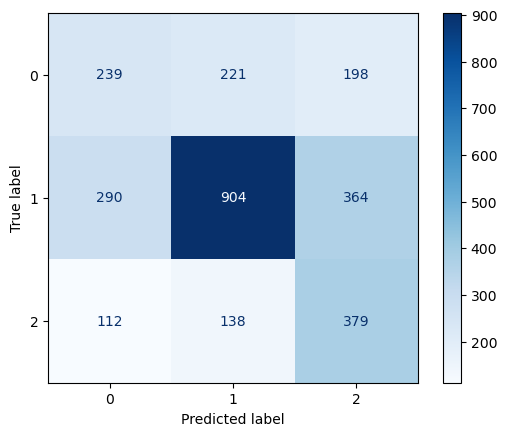

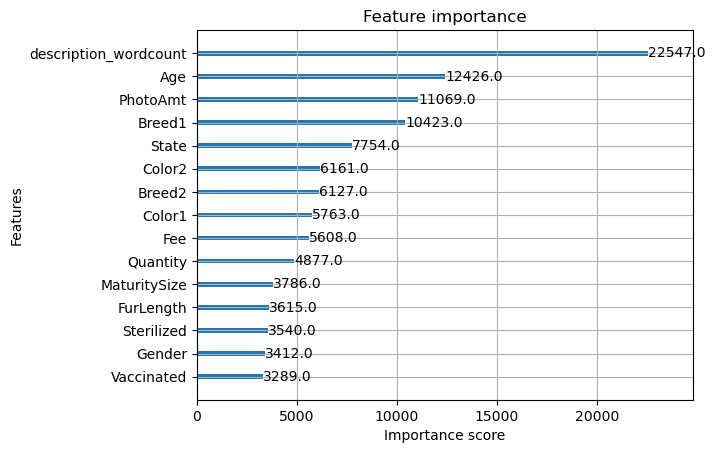

In [8]:
# === 0. Imports ===
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt

# === 1. CSVs laden ===
X_train_res = pd.read_csv("Data/preprocessed/X_train_res.csv")
y_train_res = pd.read_csv("Data/preprocessed/y_train_res.csv")['target']

X_valid = pd.read_csv("Data/preprocessed/X_valid_enc.csv")
y_valid = pd.read_csv("Data/preprocessed/y_valid.csv")['target']

X_test = pd.read_csv("Data/preprocessed/X_test_enc.csv")
y_test = pd.read_csv("Data/preprocessed/y_test.csv")['target']

# --- Prüfen, dass alle Klassen enthalten sind ---
print("Train classes:", np.unique(y_train_res))
print("Valid classes:", np.unique(y_valid))
print("Test classes:", np.unique(y_test))

# === 3. Randomized Search über sklearn API (ohne early stopping) ===
param_dist = {
    "n_estimators": [100, 200, 500, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb_skl = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_skl,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_res, y_train_res)
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# === 4. Finaler XGBoost-Fit mit Early Stopping über DMatrix ===
# DMatrix erstellen
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Beste Parameter aus RandomizedSearchCV übernehmen
best_params = random_search.best_params_
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'seed': 42,
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample']
}

num_boost_round = best_params['n_estimators']

evals = [(dtrain, 'train'), (dvalid, 'valid')]
bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

# === 5. Test-Set Vorhersage ===
y_pred = bst.predict(dtest)
print("\nXGBoost Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# === 6. Confusion Matrix ===
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.show()

# === 7. Feature Importance ===
xgb.plot_importance(bst, importance_type='weight', max_num_features=15)
plt.show()


### GridSearch

Fitting 3 folds for each of 2240 candidates, totalling 6720 fits


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:22:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 700, 'subsample': 0.7}
Best CV score: 0.5201951440889494

Test Accuracy: 0.5353251318101934

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.38      0.37       658
           1       0.72      0.57      0.64      1558
           2       0.41      0.61      0.49       629

    accuracy                           0.54      2845
   macro avg       0.50      0.52      0.50      2845
weighted avg       0.57      0.54      0.54      2845



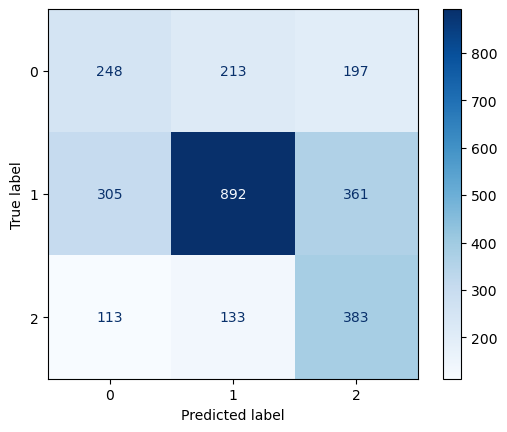

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb

# === 1. Parameter Grid definieren ===
param_grid = {
    "n_estimators": [100, 200, 500, 1000, 600, 700, 800, 900],
    "max_depth": [3, 4, 5,6,7,8,9,10],
    "learning_rate": [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "subsample": [0.8, 0.6, 0.7, 0.5, 1.0]
}

# === 2. XGBoost Modell ===
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# === 3. Grid Search ===
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_res, y_train_res)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# === 4. Bestes Modell extrahieren ===
best_model = grid_search.best_estimator_

# === 5. Evaluation auf Test-Set ===
y_pred = best_model.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 6. Confusion Matrix ===
labels_all = [0, 1, 2]  # deine drei Klassen
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.show()
